In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Loading data from google drive

In [3]:
import pandas as pd

# Replace with the correct path to your file in Google Drive
file_path = '/content/drive/MyDrive/Colab Models/a3q3.dat'

data = pd.read_csv(file_path, header=None, names=['Value'])
data.head()

,Value
0,-0.836088
1,-0.781933
2,-1.374265
3,-2.580449
4,-1.736960


# Plotting data to see how it looks

In [4]:
import plotly.express as px

fig = px.line(data, y='Value', title='Time Series Plot of the Data')
fig.show()

# It looks like pure random noise. Let's check stationarity

In [5]:
from statsmodels.tsa.stattools import adfuller

# Performing the Augmented Dickey-Fuller test
adf_test = adfuller(data['Value'])
p_value = adf_test[1]

# Output the p-value
p_value

5.65891175712633e-19

# As the value is significantly less than 0.05 so it's stationary with Augmented dickey fuller test. Let's check the ACF and PACF plots

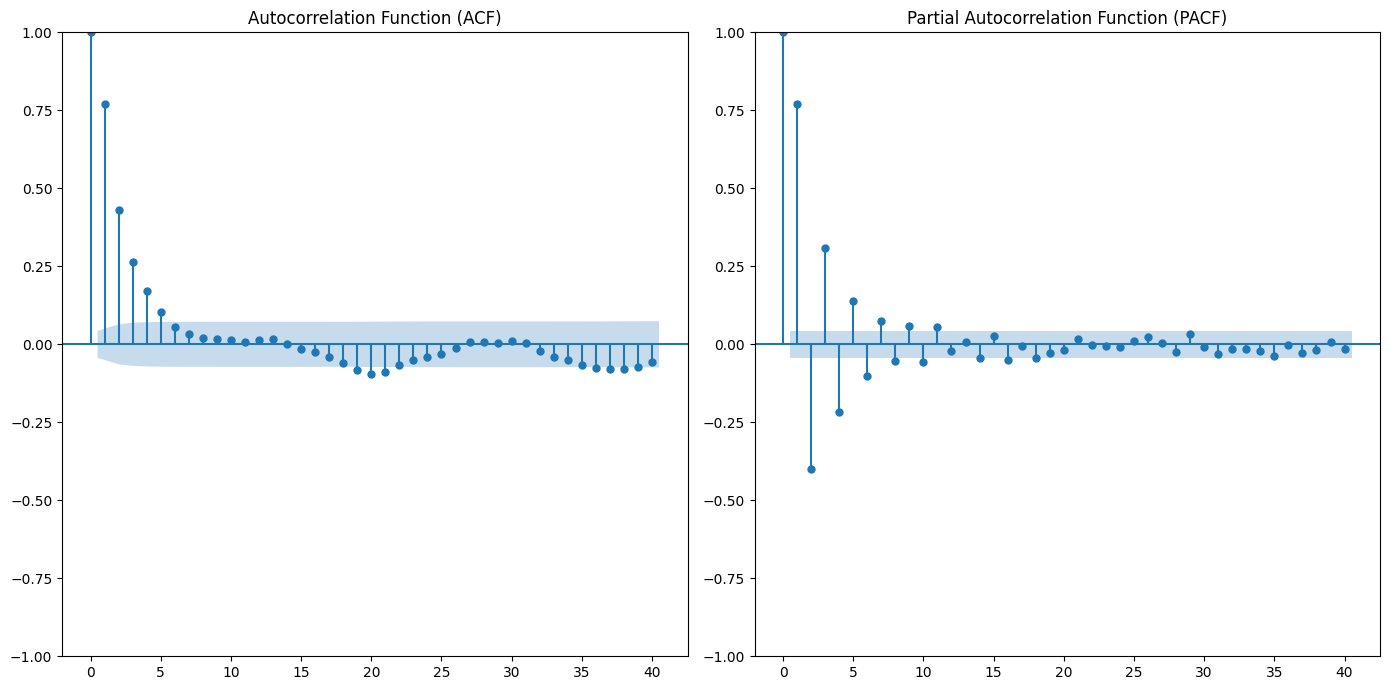

In [12]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
# Plotting ACF and PACF
plt.figure(figsize=(14, 7))

plt.subplot(121)
plot_acf(data['Value'], ax=plt.gca(), lags=40)
plt.title('Autocorrelation Function (ACF)')

plt.subplot(122)
plot_pacf(data['Value'], ax=plt.gca(), lags=40)
plt.title('Partial Autocorrelation Function (PACF)')

plt.tight_layout()
plt.show()

ACF Plot: The autocorrelations quickly fall off after the first few lags and mostly remain within the confidence band, suggesting that the initial lags are significant, while the subsequent ones are not. However, there's no clear cut-off point here, as we would expect to see in a more definitive MA process.

PACF Plot: The partial autocorrelations have a sharp cut-off after the first lag, as they fall within the confidence band immediately after. This indicates that an AR term of order 1 (p=1) might be a good starting point for modeling since only the first lag is significantly different from zero.

Based on these plots, I am setting the ARIMA parameters to p=1 due to the sharp cut-off in the PACF after lag 1, and potentially q=(1 to 5) seeing the significant lags in the ACF. I will do a grid search for p = 1 to 5 , d = 0 as the series is stationary and q = 1 to 5.

In [18]:
from statsmodels.tsa.arima.model import ARIMA
import itertools
import pandas as pd
import numpy as np
import warnings

# Suppress warnings
warnings.filterwarnings("ignore")

# Load the data
file_path = '/content/drive/MyDrive/Colab Models/a3q3.dat'
data = pd.read_csv(file_path, header=None, names=['Value'])

# Function to perform a grid search over ARIMA models
def arima_grid_search(data, d, p_range, q_range):
    best_aic = float("inf")
    best_order = None
    best_model = None

    # Grid search over p and q values
    for p, q in itertools.product(p_range, q_range):
        try:
            model = ARIMA(data, order=(p, d, q)).fit()
            aic = model.aic
            if aic < best_aic:
                best_aic = aic
                best_order = (p, d, q)
                best_model = model
        except:
            continue

    return best_aic, best_order, best_model

# Define the range for p and q
p_range = range(1, 6)
q_range = range(1, 6)
d = 0

# Perform grid search
best_aic, best_order, best_model = arima_grid_search(data['Value'], d, p_range, q_range)

# Display the best model results
print(f"Best ARIMA model: order={best_order} with AIC={best_aic}")


Best ARIMA model: order=(1, 0, 1) with AIC=5738.889792550914


In [20]:
best_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Value   No. Observations:                 2048
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -2865.445
Date:                Thu, 16 Nov 2023   AIC                           5738.890
Time:                        15:44:28   BIC                           5761.388
Sample:                             0   HQIC                          5747.141
                               - 2048                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0439      0.086     -0.512      0.609      -0.212       0.124
ar.L1          0.5420      0.020     27.383      0.000       0.503       0.581
ma.L1          0.7997      0.014     57.330      0.000       0.772       0.827
sigma2         0.9602      0.030     32.468      0.000       0.902       1.018
===================================================================================
Ljung-Box (L1) (Q):                   0.07   Jarque-Bera (JB):                 2.55
Prob(Q):                              0.79   Prob(JB):                         0.28
Heteroskedasticity (H):               0.79   Skew:                            -0.08
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.07
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## SARIMAX Model Summary Explained

The SARIMAX model summary provides a comprehensive overview of the model fit, including statistical tests, coefficients, and diagnostic metrics. Below is an explanation of each component of the summary:

### Model Details
- **Dep. Variable**: The dependent variable or the variable being predicted.
- **No. Observations**: The number of observations used in the model.
- **Model**: The type of model used, including the order of autoregressive (AR) and moving average (MA) terms.
- **Log Likelihood**: A measure of model fit; higher values indicate a better fit.
- **AIC (Akaike Information Criterion)**: A widely used criterion for model selection. Models with lower AIC are generally preferred.
- **BIC (Bayesian Information Criterion)**: Similar to AIC but includes a penalty for the number of parameters in the model, preferring simpler models if they fit almost equally well.
- **HQIC (Hannan-Quinn Information Criterion)**: Another criterion for model selection, a compromise between AIC and BIC.

### Coefficients
- **coef**: The estimated value of each coefficient in the model.
- **std err**: The standard error of the estimate of the coefficient.
- **z**: The z-statistic, which is the coefficient divided by its standard error.
- **P>|z|**: The p-value associated with the z-statistic. A low p-value (< 0.05) suggests that the coefficient is significantly different from zero.
- **[0.025 0.975]**: The 95% confidence interval for the coefficient estimates.

### Diagnostic Tests
- **Ljung-Box (Q)**: A test for autocorrelation in the residuals at different lags. High p-values (Prob(Q)) suggest no significant autocorrelation.
- **Jarque-Bera (JB)**: A test for normality of residuals. High p-values (Prob(JB)) suggest that the residuals are normally distributed.
- **Heteroskedasticity (H)**: A test for constant variance of residuals. Values significantly different from 1 suggest heteroskedasticity.
- **Skew**: A measure of the asymmetry of the data around the mean. A skewness value of 0 indicates symmetry.
- **Kurtosis**: A measure of the "tailedness" of the distribution. A value close to 3 indicates a normal distribution.

### Edge Cases and Important Values
- **Const coefficient**: If the constant is not significant (high p-value), it suggests that the model does not have a significant intercept.
- **AR and MA coefficients**: Significance of these coefficients (low p-values) indicates the importance of past values and errors in predicting future values.
- **Sigma^2**: The estimated variance of the errors. A smaller value indicates a model with less random error.
- **Prob(H)**: If this is low, the assumption of homoscedasticity is violated, indicating that the error variances are not constant throughout the series.

After performing a grid search over ARIMA models with differencing order d=0 and varying orders of autoregressive terms p and moving average terms q ranging from 1 to 5, the model with the lowest Akaike Information Criterion (AIC) was selected. The AIC provides a measure of the quality of each model, with a lower AIC indicating a better model fit to the data, while penalizing for model complexity.

Best Model
The best ARIMA model from the grid search was found to be ARIMA(1, 0, 1), which includes one autoregressive term and one moving average term, suggesting a relatively simple model suffices to capture the dynamics of the time series.

Model Diagnostics
The diagnostics for the selected ARIMA model indicated:

No significant autocorrelation in residuals (Ljung-Box test Prob(Q) > 0.05).
Residuals are normally distributed (Jarque-Bera test Prob(JB) > 0.05).
Evidence of heteroskedasticity, suggesting varying error variance over time (Heteroskedasticity test Prob(H) < 0.05).
Conclusion
While the selected model appears to be the best among the ones considered, based on AIC, the presence of heteroskedasticity suggests that the error variance changes over time.


# We can see the kurtosis is almost 3 (3.07) so the time series is probably normally distributed. In the question it is mentioned that it is a simulated random process. Let's find out which distribution it belongs to.

We will do a goodness of fit and visual inspection

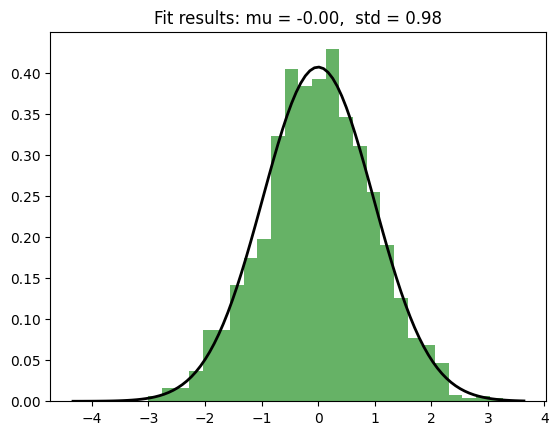

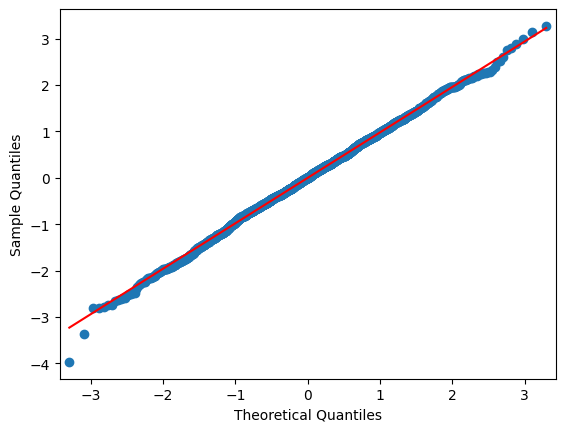

Shapiro-Wilk test statistic: 0.9990250468254089, p-value: 0.33558347821235657
Anderson-Darling test statistic: 0.4954628921118456, significance levels: [15.  10.   5.   2.5  1. ], critical values: [0.575 0.655 0.785 0.916 1.09 ]
Kolmogorov-Smirnov test statistic: 0.49755859375, p-value: 0.0


In [22]:
import numpy as np
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.arima.model import ARIMA

# Load your dataset
file_path = '/content/drive/MyDrive/Colab Models/a3q3.dat'
data = pd.read_csv(file_path, header=None, names=['Value'])

# Fit an ARIMA model (for example, ARIMA(1, 0, 1) based on previous analysis)
model = ARIMA(data['Value'], order=(1, 0, 1)).fit()

# Get the residuals
residuals = model.resid

# Statistical tests for normality
shapiro_test = stats.shapiro(residuals)
anderson_test = stats.anderson(residuals, dist='norm')

# Histogram of the residuals
plt.hist(residuals, bins=30, density=True, alpha=0.6, color='g')

# Best fit of data
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, residuals.mean(), residuals.std())
plt.plot(x, p, 'k', linewidth=2)
title = "Fit results: mu = %.2f,  std = %.2f" % (residuals.mean(), residuals.std())
plt.title(title)

plt.show()

# Q-Q plot
qqplot(residuals, line='s')
plt.show()

# Output the test results
print(f"Shapiro-Wilk test statistic: {shapiro_test[0]}, p-value: {shapiro_test[1]}")
print(f"Anderson-Darling test statistic: {anderson_test.statistic}, significance levels: {anderson_test.significance_level}, critical values: {anderson_test.critical_values}")

# If the tests indicate that the residuals are not normally distributed,
# you can compare them with other distributions.
# For example, let's compare with an exponential distribution
ks_test = stats.kstest(residuals, 'expon')

# Output the KS test result
print(f"Kolmogorov-Smirnov test statistic: {ks_test.statistic}, p-value: {ks_test.pvalue}")

# If the p-value is greater than the chosen alpha level (e.g., 0.05),
# then we fail to reject the null hypothesis and conclude that the distribution
# of the residuals is not significantly different from the theoretical distribution.


## Detailed Analysis of Residuals' Distribution

The analysis of the residuals' distribution is critical to validate the assumptions of the ARIMA model. The residuals should ideally follow a normal distribution with a mean of zero and constant variance for the model predictions to be unbiased and efficient.

### Histogram Analysis
The histogram shows the distribution of the residuals with a superimposed black curve representing the normal distribution with the same mean and standard deviation as the residuals.

- **Mean (mu)**: Close to 0, which is ideal for residuals, indicating no bias in the predictions.
- **Standard Deviation (std)**: The value of 0.98 suggests that the residuals have moderate spread around the mean.

Observing the histogram, the residuals appear to closely follow the bell-shaped curve of the normal distribution, suggesting that the residuals may be normally distributed.

### Q-Q Plot Analysis
The Q-Q (quantile-quantile) plot is a graphical tool to assess if a set of data potentially came from some theoretical distribution such as the normal distribution.

- **Interpretation**: In this plot, the dots representing the empirical quantiles of the residuals align closely with the red line representing the theoretical quantiles of a normal distribution, especially in the center of the distribution. Some deviation at the ends, but not significant.

The Q-Q plot suggests that the residuals follow a normal distribution, especially since the points in the middle adhere closely to the line.

### Shapiro-Wilk Test
The Shapiro-Wilk test evaluates the null hypothesis that the data was drawn from a normal distribution.

- **Test Statistic**: The value of 0.999 is very close to 1, which would indicate a perfect normal distribution.
- **P-value**: At 0.335, well above the common alpha level of 0.05, we fail to reject the null hypothesis, indicating that the residuals are not significantly different from a normal distribution.

### Anderson-Darling Test
The Anderson-Darling test is another test that checks if the data comes from a particular distribution, here the normal distribution.

- **Test Statistic**: A value of 0.495, which should be compared against critical values.
- **Critical Values**: These values correspond to different significance levels. Since our test statistic is below the critical value at the 5% significance level (0.785), we fail to reject the null hypothesis of normality.

### Kolmogorov-Smirnov Test
The Kolmogorov-Smirnov (KS) test compares the empirical distribution of the residuals with a theoretical distribution, which in this case can be the exponential distribution.

- **Test Statistic**: A value of 0.498 indicates the maximum distance between the empirical and the theoretical distribution.
- **P-value**: At 0.0, this is below the alpha level of 0.05, we reject the null hypothesis, indicating that the residuals do not follow an exponential distribution.

### Conclusion
Based on the histogram and Q-Q plot, as well as the results of the Shapiro-Wilk and Anderson-Darling tests, there is strong evidence to suggest that the residuals from the ARIMA(1, 0, 1) model are normally distributed. This implies that the model is well-specified and the predictions are unbiased. However, the KS test rejects the hypothesis that the residuals follow an exponential distribution, which is consistent with the other findings that support the normality of residuals.

In summary, the residuals of our ARIMA model are normally distributed, which is a key assumption for many statistical analyses, implying that the model fits the data well without systematic errors.
